This notebook tracks the disappearance of WM information using dPCA:
(1) build a baseline distribution of dispersion values by bootstrapping;
(2) compare dispersion of timesteps of interest against 95th percentile of distribution;
(3) plot the baseline distribution and dispersion of timesteps of interest;
(4) plot the 5-trial timecourse of PMI means in the PMI subspace.

In [ ]:
!pip install dpca

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
%cd /content/gdrive/My Drive/dpca_code_V2
from pumi_5tr_bootstrap import * 
import dpca as dp
from fit_scaling import *
import plotting as pf
import matplotlib.pyplot as plt

from google.colab import files
from scipy import io
from scipy import stats

In [ ]:
#function to calculate dispersion 
def disp_calc(a):
  disp = np.sum((a - np.mean(a,0))**2)/6
  return disp

# build a baseline distribution of dispersion values by bootstrapping
dataset = 'rnn'
num_unit = 60
num_sub = 10
num_boot = 10000
ndim = 2
%cd /content/gdrive/My Drive/data/2Bonly_60units_5tr_circ

num_tps = 15 #5 trials
disp_null = np.zeros((num_boot+1)) #distribution of dispersion values
X_orig = np.zeros((6,15,2))

for subject_id in np.array([2]): #only use subject #3 as an example
  for iboot in range(num_boot+1):

    if iboot == 0:
      bootstrap = 0 #first iteration is not bootstrapped
    else:
      bootstrap = 1

    pmi_wholeTrial = load_data_rnn(subject_id+1, num_unit = num_unit, tw = None, dataset = dataset, bootstrap = bootstrap)
    
    pmi_tmp = pmi_wholeTrial[:,8,:][:,np.newaxis,:]
    pmi_tmp = center(pmi_tmp) 
    ori_model = dp.dPCA(pmi_tmp, n_dim = ndim, old_version=True) #only look at projections in the PMI subspace
    d = ori_model.decoder

    X = np.matmul(center(pmi_wholeTrial),d)

    if iboot == 0:
      X_orig = X
    
    #choose the max of 3 baseline dispersion values 
    disp_null[iboot] = np.max(np.array([disp_calc(X[:,0,:]),disp_calc(X[:,1,:]),disp_calc(X[:,2,:])])) 

    if iboot %20 == 0:
      print(iboot)

In [ ]:
#calculate the dispersion of each timestep in the timecourse
disp_orig = np.zeros((15))
for tp in range(15):
  tmp = X_orig[:,tp,:]
  disp_orig[tp] = np.sum((tmp - np.mean(tmp,0))**2)/6
np.around(disp_orig,4)

array([0.0165, 0.0621, 0.0968, 0.1406, 0.348 , 0.1285, 0.1869, 1.5755,
       2.8738, 1.6147, 0.5068, 0.053 , 0.0075, 0.0233, 0.0665])

In [ ]:
#find the 95th percentile of the distribution of dispersion values
np.around(np.percentile(disp_null[1:],95),4)

0.1338

Text(0, 0.5, 'frequency')

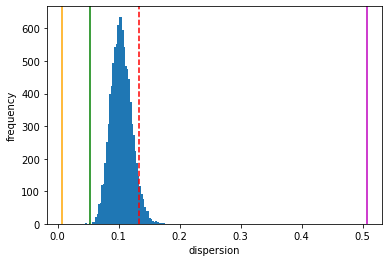

In [ ]:
#plot distribution of dispersion values and those for timesteps to test
plt.hist(disp_null[1:], bins= 50)
plt.axvline(0.1338,color = 'r',linestyle='dashed') #95th percentile criterion
plt.axvline(0.5068,color = 'm') #delay 3:1
plt.axvline(0.053,color = 'g') #delay 3:2
plt.axvline(0.0075,color = 'orange') # n+3
plt.xlabel('dispersion')
plt.ylabel('frequency')

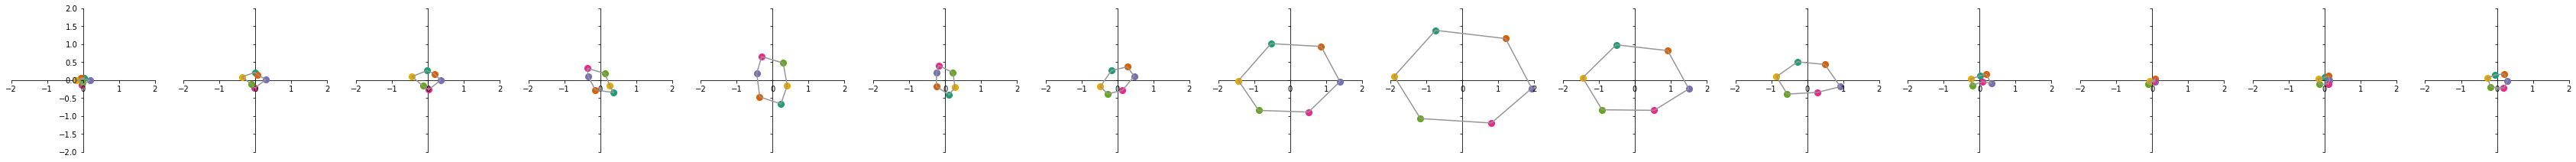

In [ ]:
#plot 5-trial timecourse of PMI means in PMI subspace
axlim = 2
# subject_id = 2
fig, axs = plt.subplots(1,num_tps, figsize=(num_tps*4, 4*1), sharex=True, sharey=True)
for i, ax in zip(np.arange(num_tps), axs):
    xy = X_orig[:,i,:]
    pf.scatter(xy, ax, symbol = False, line = True)
    ax.set_xlim([-1*axlim,1*axlim])
    ax.set_ylim([-1*axlim,1*axlim])